# Data Curation - Investigation of Wikipedia Traffic

In this notebook, we will construct and analyze a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2021.

In [15]:
import json
import requests
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

## Data Acquisition

In this portion, we will utilize the Wikimedia Foundations REST API in order to extract view count data of wikipedia across multiple access site types (desktop, app-web, app-mobile).

In [2]:
# Set endpoints without parameters

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
# Set header with personal github account, email

headers = {
    'User-Agent': 'https://github.com/TrevorNims',
    'From': 'nimstre@uw.edu'
}

In [4]:
# Define helper functions to specify parameters for each of the two types of endpoints.
# Each function allows for a single parameter to specify the type of access-site.

def set_legacy_access_site(access_site):
    params = {"project" : "en.wikipedia.org",
                 "access-site" : access_site,
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2021090100"
                    }
    return params

def set_pageviews_access_site(access_site):
    params = {"project" : "en.wikipedia.org",
                    "access" : access_site,
                    # filter out web crawlers
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2008010100",
                    "end" : '2021090100'
                        }
    return params

In [5]:
# Define function that calls wikimedia api, takes an unformatted endpoint string and 
# an endpoint parameter dictionary as parameters and returns the response of the api 
# call

def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [6]:
# Set parameters for the two types of access-sites for the legacy endpoint

legacy_desktop_params = set_legacy_access_site('desktop-site')
legacy_mobile_params = set_legacy_access_site('mobile-site')

# Set parameters for the three types of access-sites for the pageviews endpoint

pageviews_desktop_params = set_pageviews_access_site('desktop')
pageviews_mobile_web_params = set_pageviews_access_site('mobile-web')
pageviews_mobile_app_params = set_pageviews_access_site('mobile-app')

In [7]:
# Create lists of the endpoint parameters, their respective unformatted endpoints,
# and their json filenames 

all_params = [legacy_desktop_params, legacy_mobile_params, pageviews_desktop_params,
             pageviews_mobile_web_params, pageviews_mobile_app_params]

all_endpoints = [endpoint_legacy, endpoint_legacy, endpoint_pageviews,
                endpoint_pageviews, endpoint_pageviews]

all_filenames = ['pagecounts_desktop-site_200801-202108.json', 'pagecounts_mobile-site_200801-202108.json',
                'pageviews_desktop_200801-202108.json', 'pageviews_mobile-web_200801-202108.json', 
                'pageviews_mobile-app_200801-202108.json']

In [8]:
# Make an api call for each endpoint parameter dictionary and save the
# results in a json file with the matching filename.

for endpoint, params, filename in zip(all_endpoints, all_params, all_filenames):
    data = api_call(endpoint, params)
    # remove singular json parent wrapper provided by api
    data = data['items']
    with open('data/' + filename, 'w') as json_file:
        json.dump(data, json_file)   

## Data Processing

We have now saved a dataset for each type of access-site (5 in all) in the json format, and can continue with data cleaning. This will consist of aggregating the .json files produced earlier into a single pandas dataframe that contains view counts over time for each of the access sites.

In [10]:
# Create column name list for distinction between view counts

count_column_name_list = ['pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_desktop_views',
                         'pageview_mobile-web_views', 'pageview_mobile-app_views']

# Instantiate list to hold each individual dataframe prior to merge
df_merge_list = []

for i, filename in enumerate(all_filenames):
    # Read in data into a pandas dataframe, ensuring that pandas 
    # does not try to auto-convert the timestamp (will result in incorrect dates)
    df = pd.read_json('data/' + filename, convert_dates=False)
    
    # Specify whether the view count column is labeled 'count' or 'views', this depends
    # on the ordering of 'all_filenames'
    keyword = 'count'
    if i > 1:
        keyword = 'views'
    # re-arrange timestamp to match desired format
    years = df['timestamp'].apply(lambda x: str(x)[0:4])
    months = df['timestamp'].apply(lambda x: str(x)[4:6])
    df['year'] = years
    df['month'] = months
    df = df[['year', 'month', keyword]]
    # re-label view count column
    column_name = count_column_name_list[i]
    df = df.rename(columns={keyword : column_name})
    df_merge_list.append(df)

In [11]:
# Merge all dataframes in 'df_merge_list', filling NaN values with 0

df_merged = reduce(lambda  left,right: pd.merge(left, right, how='outer'), df_merge_list).fillna(0)

# Manipulate 'df_merged' to calculate derived columns, combine pageview app view counts into single column
df_merged['pagecount_all_views'] = df_merged['pagecount_desktop_views'] + df_merged['pagecount_mobile_views']
df_merged['pageview_mobile_views'] = df_merged['pageview_mobile-web_views'] + df_merged['pageview_mobile-app_views']
df_merged = df_merged.drop(columns=['pageview_mobile-web_views', 'pageview_mobile-app_views'], axis = 1)
df_merged['pageview_all_views'] = df_merged['pageview_desktop_views'] + df_merged['pageview_mobile_views']

In [12]:
# Save dataframe to csv file

df_merged.to_csv('data/en-wikipedia_traffic_200801-202108.csv')

## Data Analysis

Now we will create a graph of the data to visually analyze traffic trends, aggregating the view count data into three columns: Mobile Traffic, Desktop Traffic, and All Traffic.

In [13]:
# Create new column 'date' as a datetime representation of 'year' and 'month' columns

df_merged['date'] = df_merged['month'] + '-' + df_merged['year']
df_merged['date'] = pd.to_datetime(df_merged['date'], format='%m-%Y')

In [16]:
# Create list of columns that will be created for the final visualization
traffic_display_names = ['Mobile Traffic', 'Desktop Traffic', 'All Traffic']

# Create the final columns
df_merged[traffic_display_names[0]] = df_merged['pagecount_mobile_views'] + df_merged['pageview_mobile_views']
df_merged[traffic_display_names[1]] = df_merged['pagecount_desktop_views'] + df_merged['pageview_desktop_views']
df_merged[traffic_display_names[2]] = df_merged['Desktop Traffic'] + df_merged['Mobile Traffic']

# Replace zero values with NaN to prevent them from being plotted
df_merged.replace(0, np.NaN, inplace=True)

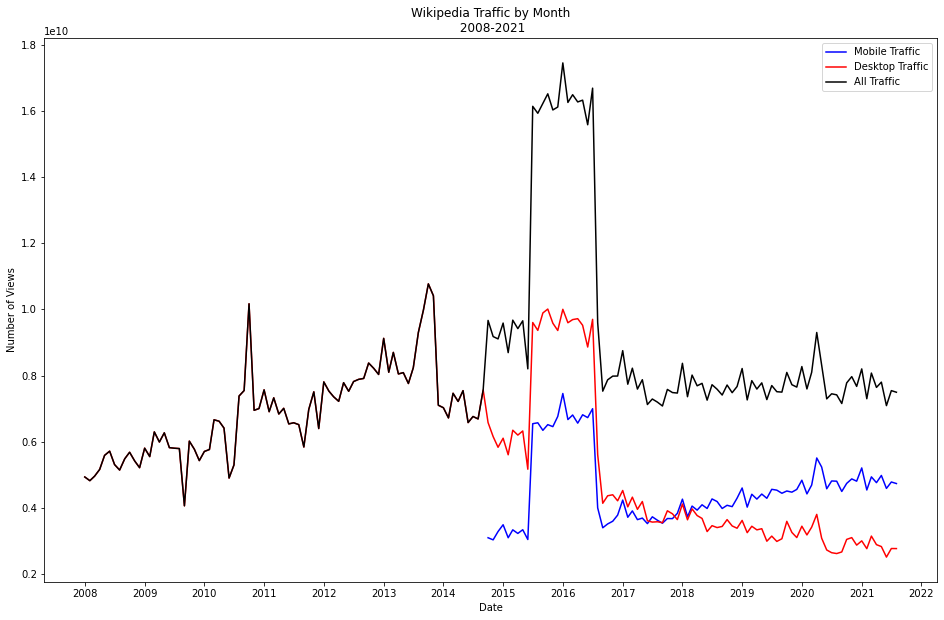

In [18]:
# Create plot, save figure

fig, ax = plt.subplots(figsize=(16, 10))
colors = ['b', 'r', 'k']
for i, col_name in enumerate(traffic_display_names):
    ax.plot(df_merged['date'], df_merged[col_name], color=colors[i])

ax.set(xlabel="Date", ylabel='Number of Views',
       title='Wikipedia Traffic by Month\n 2008-2021')
ax.legend(traffic_display_names)

# Format the x axis to show years only
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.savefig('visualizations/Wikipedia_Traffic_By_Month.png', facecolor ='w', edgecolor ='w')
plt.show()

As can be seen above, traffic was originally confined solely to desktop views. However, in late 2014, mobile access  was initiated, with a huge spike in traffic seen soon after its advent.